# DTM Inputs

Derive inputs for the DTM model. 

Inputs:
- instantaneous flux at (t - 24hr)    /   f(2)=0.
- mean flux of last 81 days at t   /   fbar(2)=0.
- kp delayed by 3 hours
- mean kp of last 24 hours

- hl - local time in radians (0-24 -> 0-2pi)

The solar flux has to be interpolated to the decimal date for the 81-day mean, and interpolated to the decimal date minus 24hr for the daily flux (i.e., 1-day delayed instantaneous flux). The kp has to be computed from similarly interpolated ap values: interpolate linearly from one to the next 3-hourly ap value, then convert back to kp.

Kp = 0o   0+   1-   1o   1+   2-   2o   2+   3-   3o   3+   4-   4o   4+
Kp = 0. 0.33 0.66 1.00 1.33 1.66 2.00 2.33 2.66 3.00 3.33 3.66 4.00 4.33    
ap =  0    2    3    4    5    6    7    9   12   15   18   22   27   32

Kp =   5-   5o   5+   6-   6o   6+   7-   7o   7+   8-   8o   8+   9-   9o
Kp = 4.66 5.00 5.33 5.66 6.00 6.33 6.66 7.00 7.33 7.66 8.00 8.33 8.66 9.00   
ap =   39   48   56   67   80   94  111  132  154  179  207  236  300  400

In [1]:
import os, sys
import pandas as pd
import numpy as np

from scipy import interpolate

#add read_io module to current path ()
file_path = 'D:\\GitHub\\DataIO\\'
sys.path.append(os.path.dirname(file_path))

# import data input/output module
import data_io as dio

In [2]:
AP_vals = [0, 2, 3, 4, 5, 6, 7, 9, 12, 15, 18, 22, 27, 32,\
           39, 48, 56, 67, 80, 94, 111, 132, 154, 179, 207, 236, 300, 400]

KP_vals = [0., 0.33, 0.66, 1.00, 1.33, 1.66, 2.00, 2.33, 2.66, 3.00, 3.33, 3.66, 4.00, 4.33,\
           4.66, 5.00, 5.33, 5.66, 6.00, 6.33, 6.66, 7.00, 7.33, 7.66, 8.00, 8.33, 8.66, 9.00] 
    

In [3]:
# read champ data
ch_d = pd.read_hdf("D:\\data\\SatDensities\\satdrag_database_grace_CHAMP.hdf5")

date_min = ch_d['DateTime'].min()
date_max = ch_d['DateTime'].max()

In [76]:
ch_d.columns

Index(['DateTime', 'DateTime_omni', 'B', 'Bx_GSEGSM', 'By_GSE', 'Bz_GSE',
       'By_GSM', 'Bz_GSM', 'Vsw', 'Vx_GSE', 'Vy_GSE', 'Vz_GSE', 'Prho', 'Tp',
       'dynP', 'Esw', 'AE', 'AL', 'AU', 'SYM_D index', 'SYM_H index',
       'ASY_D index', 'ASY_H index', 'PC index', 'Goes Proton flux (>10 MeV)',
       'Goes Proton flux (>30 MeV)', 'Goes Proton flux (>60 MeV)',
       'DateTime_fism2', '225_00', '600_01', '1300_02', '2500_03', '5100_04',
       '11250_05', '18950_06', '25700_07', '30500_08', '43000_09', '59500_10',
       '72400_11', '72400_12', '85550_13', '85550_14', '85550_15', '94400_16',
       '94400_17', '94400_18', '98100_19', '100700_20', '103850_21',
       '113000_22', 'DateTime_si', 'F10', 'F81', 'S10', 'S81c', 'M10', 'M81c',
       'Y10', 'Y81c', 'DateTime_gr', 'CenterLat', 'SatLat', 'SatLon',
       'SatHeight', 'SatLT', 'SatDipoleLat', 'SatMagLon', 'SatMagLT',
       'SatDensity', '400kmDensity', '410kmDensity', 'NRLMSISe00atSat',
       'DenUncertainty', 'NumPts', '

In [ ]:
st_d = ch_d['storm'] > 0

ch_i = ch_d.loc[st_d,['DateTime','CenterLat', 'SatLat', 'SatLon',
       'SatHeight', 'SatLT', 'SatMagLat', 'SatMagLon', 'SatMagLT',
       'SatDensity', '400kmDensity']].dropna().copy()

KeyError: "['SatMagLat'] not in index"

In [5]:
# read in 1 hour omni data which has the ap values in it 
om_d, om_m = dio.load_omni(res='1h',sdate=date_min, edate=date_max)

In [6]:
om_i = om_d[['DateTime','Kp','AP']].copy()
# create a timestamp (seconds past 1970)
# so that we can interpolate
om_i['TimeStamp'] = [x.timestamp() for x in om_i['DateTime']]
om_i.head(3)

,DateTime,Kp,AP,TimeStamp
0,2002-01-01 00:00:00,23.0,9.0,1.009843e+09
1,2002-01-01 01:00:00,23.0,9.0,1.009847e+09
2,2002-01-01 02:00:00,23.0,9.0,1.009850e+09


In [7]:
# create a 5 minute time axis and convert to timestamps for interpolation
int_time = pd.date_range(start=om_i['DateTime'].min(), end=om_i['DateTime'].max(), freq='5min')
int_ts = [x.timestamp() for x in int_time]

# create the interpolation
f_int = interpolate.interp1d(om_i['TimeStamp'].to_numpy(), om_i['AP'].to_numpy())

# interpolate
ap_int = f_int(int_ts)

In [8]:
ak_i = pd.DataFrame({'DateTime':int_time, 'AP':ap_int, 'KP':np.empty(ap_int.shape)}) 
ak_i.loc[:,'KP'] = np.nan
ak_i.head()

,DateTime,AP,KP
0,2002-01-01 00:00:00,9.0,NaN
1,2002-01-01 00:05:00,9.0,NaN
2,2002-01-01 00:10:00,9.0,NaN
3,2002-01-01 00:15:00,9.0,NaN
4,2002-01-01 00:20:00,9.0,NaN


In [9]:
# create new interpolated dataframe and fill with respective KP values
ak_i = pd.DataFrame({'DateTime':int_time, 'AP':ap_int, 'Kp':np.empty(ap_int.shape)}) 
ak_i.loc[:,'Kp'] = np.nan

for bot, top, kp in zip(AP_vals[:-1], AP_vals[1:], KP_vals[:-1]):
    print(bot,top,kp)

    dat = (ak_i['AP'] >= bot) & (ak_i['AP'] <= top)
    ak_i.loc[dat,'Kp'] = kp

0 2 0.0
2 3 0.33
3 4 0.66
4 5 1.0
5 6 1.33
6 7 1.66
7 9 2.0
9 12 2.33
12 15 2.66
15 18 3.0
18 22 3.33
22 27 3.66
27 32 4.0
32 39 4.33
39 48 4.66
48 56 5.0
56 67 5.33
67 80 5.66
80 94 6.0
94 111 6.33
111 132 6.66
132 154 7.0
154 179 7.33
179 207 7.66
207 236 8.0
236 300 8.33
300 400 8.66


In [10]:
# calculate the rolling average of kp
ak_i['Kp_avg'] = ak_i[['DateTime','Kp']].rolling('24h',on='DateTime').mean()['Kp']

In [ ]:
# shift kp 3 hours and add back on
kp_sh = ak_i[['DateTime','Kp']].copy()
kp_sh['DateTime'] = kp_sh['DateTime'] + pd.Timedelta('3hour')

In [12]:
ak_i = pd.merge_asof(left=ak_i.set_index('DateTime'),right=kp_sh.set_index('DateTime'),right_index=True,left_index=True,direction='nearest',tolerance=pd.Timedelta('1m'))

In [13]:
ak_i = ak_i.rename(columns={'Kp_x':'Kp','Kp_y':'Kp_3hr_shift'}).reset_index()

In [15]:
ak_i.tail()

,DateTime,AP,Kp,Kp_avg,Kp_3hr_shift
946640,2010-12-31 22:40:00,2.0,0.33,0.939132,0.66
946641,2010-12-31 22:45:00,2.0,0.33,0.935660,0.66
946642,2010-12-31 22:50:00,2.0,0.33,0.932187,0.66
946643,2010-12-31 22:55:00,2.0,0.33,0.928715,0.66
946644,2010-12-31 23:00:00,2.0,0.33,0.925243,0.66


<Axes: xlabel='DateTime'>

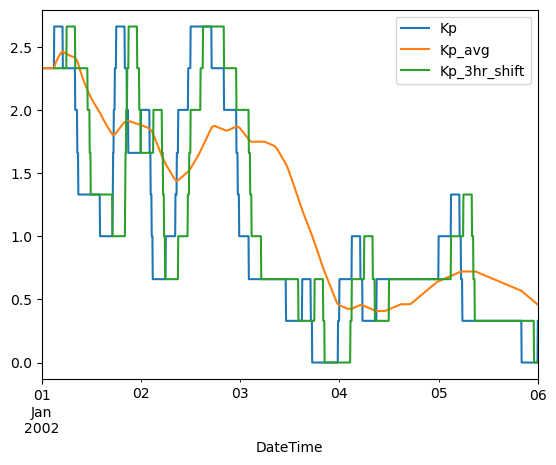

In [16]:
ak_i[0:1441].plot(x='DateTime', y=['Kp','Kp_avg','Kp_3hr_shift'])

In [42]:
flx_d = pd.read_csv('D:\\data\\Solar\\fluxtable.txt',sep='\s+', skiprows=[1], parse_dates={'DateTime_flux':[0,1]},keep_date_col=True)

C:\Users\krmurph1\AppData\Local\Temp\ipykernel_33296\3749155829.py:1: FutureWarning: The 'keep_date_col' keyword in pd.read_csv is deprecated and will be removed in a future version. Explicitly remove unwanted columns after parsing instead.
  flx_d = pd.read_csv('D:\\data\\Solar\\fluxtable.txt',sep='\s+', skiprows=[1], parse_dates={'DateTime_flux':[0,1]},keep_date_col=True)
C:\Users\krmurph1\AppData\Local\Temp\ipykernel_33296\3749155829.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  flx_d = pd.read_csv('D:\\data\\Solar\\fluxtable.txt',sep='\s+', skiprows=[1], parse_dates={'DateTime_flux':[0,1]},keep_date_col=True)


In [43]:
flx_d['DateTime'] = pd.to_datetime(flx_d['fluxjulian'], origin='julian', unit='D')

In [55]:
flx

,DateTime,fluxobs
0,2004-10-28 17:29:45.599984232,132.700000
1,2004-10-28 17:34:45.599984232,132.786111
2,2004-10-28 17:39:45.599984232,132.872222
3,2004-10-28 17:44:45.599984232,132.958333
4,2004-10-28 17:49:45.599984232,133.044444
...,...,...
2110798,2024-11-21 21:19:45.599984232,169.456680
2110799,2024-11-21 21:24:45.599984232,169.626157
2110800,2024-11-21 21:29:45.599984232,169.795635
2110801,2024-11-21 21:34:45.599984232,169.965112


In [56]:
flx_i = flx_d[['DateTime','fluxobsflux']].copy()
flx_i['TimeStamp'] = [x.timestamp() for x in flx_d['DateTime']]

# create the interpolation
flx_f = interpolate.interp1d(flx_i['TimeStamp'].to_numpy(), flx_i['fluxobsflux'].to_numpy())

# create a 5 minute time axis and convert to timestamps for interpolation
int_time = pd.date_range(start='2004-10-28 17:30:00', end='2024-11-21 21:35:00', freq='5min')
int_ts = [x.timestamp() for x in int_time]

# interpolate
flx_int = flx_f(int_ts)

In [ ]:
# create new dataframe
flx = pd.DataFrame({'DateTime':int_time, 'fluxobs':flx_int}) 
flx.head()

,DateTime,fluxobs
0,2004-10-28 17:30:00,132.704133
1,2004-10-28 17:35:00,132.790244
2,2004-10-28 17:40:00,132.876356
3,2004-10-28 17:45:00,132.962467
4,2004-10-28 17:50:00,133.048578


In [59]:
# calculate required averages
# calculate the rolling average of kp
flx['flux_avg'] = flx[['DateTime','fluxobs']].rolling('81d',on='DateTime').mean()['fluxobs']

In [69]:
# shift flux 24 hours hours and add back on
flx_sh = flx[['DateTime','fluxobs']].copy()
flx_sh['DateTime'] = flx_sh['DateTime'] + pd.Timedelta('24hour')

flx = pd.merge_asof(left=flx.set_index('DateTime'),right=flx_sh.set_index('DateTime'),right_index=True,left_index=True,direction='nearest',tolerance=pd.Timedelta('1m'))

In [70]:
flx = flx.rename(columns={'fluxobs_x':'fluxobs','fluxobs_y':'flux_24hr_shift'}).reset_index()

In [71]:
#print all output in a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# check all the data
flx.head()
ak_i.head()
ch_i.head()

,DateTime,fluxobs,flux_avg,Kp_24hr_shift,flux_24hr_shift
0,2004-10-28 17:30:00,132.704133,132.704133,NaN,NaN
1,2004-10-28 17:35:00,132.790244,132.747189,NaN,NaN
2,2004-10-28 17:40:00,132.876356,132.790244,NaN,NaN
3,2004-10-28 17:45:00,132.962467,132.833300,NaN,NaN
4,2004-10-28 17:50:00,133.048578,132.876356,NaN,NaN


,DateTime,AP,Kp,Kp_avg,Kp_3hr_shift
0,2002-01-01 00:00:00,9.0,2.33,2.33,NaN
1,2002-01-01 00:05:00,9.0,2.33,2.33,NaN
2,2002-01-01 00:10:00,9.0,2.33,2.33,NaN
3,2002-01-01 00:15:00,9.0,2.33,2.33,NaN
4,2002-01-01 00:20:00,9.0,2.33,2.33,NaN


,DateTime,CenterLat,SatLat,SatLon,SatHeight,SatLT,SatDipoleLat,SatMagLon,SatMagLT,SatDensity,400kmDensity
6372,2002-01-23 03:00:00,84.0,84.60454,163.65177,438.650,13.9037,79.21305,-158.86591,11.2071,3.177101e-12,5.835804e-12
6373,2002-01-23 03:05:00,75.0,75.51179,-58.41539,441.755,23.1812,81.94785,42.56934,0.7143,2.090392e-12,4.110030e-12
6374,2002-01-23 03:10:00,54.0,54.19289,-52.99141,439.892,23.6359,60.38927,31.72940,0.0815,2.773187e-12,5.312346e-12
6375,2002-01-23 03:15:00,36.0,35.89786,-52.37619,435.446,23.7560,40.98679,28.91716,23.9715,3.044084e-12,5.416350e-12
6376,2002-01-23 03:20:00,18.0,18.48770,-52.44368,430.841,23.8265,23.17999,25.41538,23.8123,3.399799e-12,5.596856e-12


In [73]:
dtm_database = pd.merge_asof(left=ch_i.set_index('DateTime'),right=ak_i.set_index('DateTime'),right_index=True,left_index=True,direction='nearest',tolerance=pd.Timedelta('1m')) 
dtm_database = pd.merge_asof(left=dtm_database,right=flx.drop(columns='Kp_24hr_shift').set_index('DateTime'),right_index=True,left_index=True,direction='nearest',tolerance=pd.Timedelta('1m')) 

In [77]:
dtm_database = dtm_database.dropna()

In [79]:
fn = f'D:\\data\\SatDensities\\DTM_champ_inputs.hdf5'
dtm_database.to_hdf(fn,key='database', mode='w', format='fixed', complevel=9)